In [56]:
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string

# VEST Georgia Validation

## Examining and Loading Files

### VEST

#### Copy in VEST GA 16 file

In [2]:
vest_ga = gp.read_file("./raw-from-source/VEST/ga_2016/ga_2016.shp")

In [3]:
print(vest_ga.head())

  DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2 FIPS2  \
0  121JC15  121JC15       JC15       JC15  FULTON        60        060   121   
1  12108N1  12108N1       08N1       08N1  FULTON        60        060   121   
2  12108N2  12108N2       08N2       08N2  FULTON        60        060   121   
3  121JC14  121JC14       JC14       JC14  FULTON        60        060   121   
4  121JC05  121JC05       JC05       JC05  FULTON        60        060   121   

   G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRISA  G16USSDBAR  G16USSLBUC  \
0         202         294          29         206         257          38   
1         313         232          32         445         133           6   
2         402         500          22         517         353          27   
3        1000         708          60        1199         497          39   
4         651         736          81         767         561          75   

   G16PSCRECH  G16PSCLHOS                               

#### VEST Data Sources (from documentation):

Election results from the Georgia Secretary of State Elections Division  (https://sos.ga.gov/index.php/Elections/current_and_past_elections_results)  
Precinct shapefile primarily from the Georgia General Assembly Reapportionment Office (http://www.legis.ga.gov/Joint/reapportionment/en-US/default.aspx)  

#### VEST Processing (from documentation):

Fulton County uses shapefiles and maps sourced from the county GIS program. Precincts CH01/CH04B, CP07A/CP07D, SS29A/SS29B, UC031/UC035 were merged to match how voters were registered in the 2016 voter file.

The following precincts were split by congressional district to match the 2016 election results: Avondale High, Glennwood, Wadsworth in Dekalb County; Cates D in Gwinnett County.

Cloudland and Teloga precincts in Chattooga County were split along the ridgeline that marks the boundary between them with the USGS Topographic Contour shapefile.

Three of the four VTDs in Chattahoochee County are comprised of Fort Benning. However, the county only has one polling location for all voters, including residents of Fort Benning that vote within the county. The four Chattahoochee County VTDs have therefore been merged in the shapefile.

#### VEST Field Names (from documentation):

G16PRERTRU - Donald J. Trump (Republican Party)  
G16PREDCLI - Hillary Clinton (Democratic Party)  
G16PRELJOH - Gary Johnson (Libertarian Party)  
  
G16USSRISA - Johnny Isakson (Republican Party)  
G16USSDBAR - Jim Barksdale (Democratic Party)  
G16USSLBUC - Allen Buckley (Libertarian Party)  
  
G16PSCRECH - Tim Echols (Republican Party)  
G16PSCLHOS - Eric Hoskins (Libertarian Party)  

Note: Some difficulties in using the link provided by VEST (need to do work on each county)

### MEDSL Presidential Election Precinct-Level Results

In [71]:
#Note: Some difficulties in using the link provided by VEST (need to do work on each county)
medsl_election = pd.read_csv("./raw-from-source/MEDSL/2016-precinct-president.tab",sep="\t")
medsl_election= medsl_election[medsl_election.state=="Georgia"]
medsl_election= medsl_election[["county_name","county_fips",'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes','candidate_fec', 'candidate_fec_name']]
candidate_list = ['CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE',
 'JOHNSON, JOHN FITZGERALD MR.', 'TRUMP, DONALD J. / MICHAEL R. PENCE']
medsl_election=medsl_election[medsl_election["candidate_fec_name"].isin(candidate_list)]
medsl_election['county_fips'] = medsl_election['county_fips'].astype(int)
medsl_election['county_fips'] = medsl_election['county_fips'].astype(str)
medsl_election["precinct"]=medsl_election["precinct"].str.strip()
medsl_election['county_prec'] = medsl_election['county_fips'].str[2:5]+medsl_election["precinct"]
medsl_election=pd.pivot_table(medsl_election,index=['county_prec'],columns=["candidate_fec_name"],values=['votes'],aggfunc=sum)
medsl_election.columns = medsl_election.columns.droplevel(0)
medsl_election = medsl_election.rename(columns={"CLINTON, HILLARY RODHAM / TIMOTHY MICHAEL KAINE":"G16PREDCLI","JOHNSON, JOHN FITZGERALD MR.":"G16PRELJOH","TRUMP, DONALD J. / MICHAEL R. PENCE": "G16PRERTRU"})

In [84]:
medsl_election = pd.read_csv("./raw-from-source/MEDSL/2016-precinct-president.tab",sep="\t")
medsl_election= medsl_election[medsl_election.state=="Georgia"]
print(medsl_election.head())
print(medsl_election.columns)


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (13,17,19,31,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


        year stage  special    state state_postal  state_fips  state_icpsr  \
573155  2016   gen    False  Georgia           GA          13           44   
573156  2016   gen    False  Georgia           GA          13           44   
573157  2016   gen    False  Georgia           GA          13           44   
573158  2016   gen    False  Georgia           GA          13           44   
573159  2016   gen    False  Georgia           GA          13           44   

           county_name  county_fips  county_ansi  ...  candidate_middle  \
573155  Appling County      13001.0     349113.0  ...               NaN   
573156  Appling County      13001.0     349113.0  ...               NaN   
573157  Appling County      13001.0     349113.0  ...               NaN   
573158  Appling County      13001.0     349113.0  ...               NaN   
573159  Appling County      13001.0     349113.0  ...               NaN   

        candidate_full candidate_suffix candidate_nickname candidate_fec  \
5731

### MEDSL State Elections Precinct-Level Results

In [73]:
medsl_state_election = pd.read_csv("./raw-from-source/MEDSL/2016-precinct-state.tab",sep="\t")
medsl_state_election= medsl_state_election[medsl_state_election.state=="Georgia"]
medsl_state_election= medsl_state_election[["county_name","county_fips",'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes','candidate_fec', 'candidate_fec_name']]
medsl_state_election = medsl_state_election[medsl_state_election["office"]=="PUBLIC SERVICE COMMISSION, DISTRICT 2 - EASTERN"]
medsl_state_election['county_fips'] = medsl_state_election['county_fips'].astype(int)
medsl_state_election['county_fips'] = medsl_state_election['county_fips'].astype(str)
medsl_state_election["precinct"]=medsl_state_election["precinct"].str.strip()
medsl_state_election['county_prec'] = medsl_state_election['county_fips'].str[2:5]+medsl_state_election["precinct"]
medsl_state_election=pd.pivot_table(medsl_state_election,index=['county_prec'],columns=["candidate"],values=['votes'],aggfunc=sum)
medsl_state_election.columns = medsl_state_election.columns.droplevel(0)
medsl_state_election = medsl_state_election.rename(columns={"ERIC HOSKINS":"G16PSCLHOS","TIM ECHOLS":"G16PSCRECH"})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (7,13,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### MEDSL Senate Elections Precinct-Level Results

In [74]:
medsl_senate_election = pd.read_csv("./raw-from-source/MEDSL/2016-precinct-senate.tab",sep="\t")
medsl_senate_election= medsl_senate_election[medsl_senate_election.state=="Georgia"]
medsl_senate_election= medsl_senate_election[["county_name","county_fips",'jurisdiction', 'precinct', 'candidate',
       'candidate_normalized', 'office', 'district', 'writein', 'party',
       'mode', 'votes','candidate_fec', 'candidate_fec_name']]
medsl_senate_election['county_fips'] = medsl_senate_election['county_fips'].astype(int)
medsl_senate_election['county_fips'] = medsl_senate_election['county_fips'].astype(str)
medsl_senate_election["precinct"]=medsl_senate_election["precinct"].str.strip()
medsl_senate_election['county_prec'] = medsl_senate_election['county_fips'].str[2:5]+medsl_senate_election["precinct"]
medsl_senate_election=pd.pivot_table(medsl_senate_election,index=['county_prec'],columns=["candidate"],values=['votes'],aggfunc=sum)
medsl_senate_election.columns = medsl_senate_election.columns.droplevel(0)
medsl_senate_election = medsl_senate_election.drop('Michelle Gates', 1)
medsl_senate_election = medsl_senate_election.rename(columns={"ALLEN BUCKLEY":"G16USSLBUC","JIM BARKSDALE":"G16USSDBAR","JOHNNY ISAKSON":"G16USSRISA"})

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (13,19,27,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Check Totals

In [75]:
print("MEDSL totals:")
print(medsl_election["G16PREDCLI"].sum())
print(medsl_election["G16PRELJOH"].sum())
print(medsl_election["G16PRERTRU"].sum())
print("")
print(medsl_state_election["G16PSCLHOS"].sum())
print(medsl_state_election["G16PSCRECH"].sum())
print("")
print(medsl_senate_election["G16USSLBUC"].sum())
print(medsl_senate_election["G16USSDBAR"].sum())
print(medsl_senate_election["G16USSRISA"].sum())
print("")
print("VEST totals:")
print(vest_ga["G16PREDCLI"].sum())
print(vest_ga["G16PRELJOH"].sum())
print(vest_ga["G16PRERTRU"].sum())
print("")
print(vest_ga["G16PSCLHOS"].sum())
print(vest_ga["G16PSCRECH"].sum())
print("")
print(vest_ga["G16USSLBUC"].sum())
print(vest_ga["G16USSDBAR"].sum())
print(vest_ga["G16USSRISA"].sum())

MEDSL totals:
1877963
125306
2089104

1200076
2390836

162260.0
1599726.0
2135806.0

VEST totals:
1877963
125306
2089104

1200076
2390836

162260
1599726
2135806


### Merge MEDSL results

In [76]:
medsl_election = medsl_election.reset_index()
print(medsl_election.head())

medsl_state_election = medsl_state_election.reset_index()
print(medsl_state_election.head())

medsl_senate_election = medsl_senate_election.reset_index()
print(medsl_senate_election.head())

print(medsl_election.shape)
print(medsl_state_election.shape)
print(medsl_senate_election.shape)

candidate_fec_name county_prec  G16PREDCLI  G16PRELJOH  G16PRERTRU
0                        0011B          92           9         685
1                        0011C          42           5         496
2                         0012         742          10         427
3                        0013A           4           4         209
4                       0013A1          17           1         319
candidate county_prec  G16PSCLHOS  G16PSCRECH
0               0011B          62         655
1               0011C          41         464
2                0012         344         545
3               0013A          10         193
4              0013A1          18         300
candidate county_prec  G16USSLBUC  G16USSDBAR  G16USSRISA
0               0011B        14.0        81.0       636.0
1               0011C        13.0        45.0       455.0
2                0012        28.0       581.0       445.0
3               0013A         3.0         6.0       194.0
4              0013A1         9.

In [77]:
#Merge presidential and state election results
medsl_state_pres=pd.merge(medsl_election,medsl_state_election,on='county_prec',how='outer',indicator=True)
print(medsl_state_pres.shape)
print(medsl_state_pres)
medsl_state_pres = medsl_state_pres.drop('_merge', 1)

#Merged pres+state with senate results
medsl_all = pd.merge(medsl_state_pres,medsl_senate_election,on='county_prec',how='outer',indicator=True)
print(medsl_all.shape)
print(medsl_all[medsl_all["_merge"]=="right_only"])
medsl_final = medsl_all[medsl_all["_merge"]=="both"]
medsl_final = medsl_final.drop('_merge', 1)

#the "right_only" files seem to just be write ins


(2693, 7)
         county_prec  G16PREDCLI  G16PRELJOH  G16PRERTRU  G16PSCLHOS  \
0              0011B          92           9         685          62   
1              0011C          42           5         496          41   
2               0012         742          10         427         344   
3              0013A           4           4         209          10   
4             0013A1          17           1         319          18   
...              ...         ...         ...         ...         ...   
2688     321Shingler          47           4         337          26   
2689       321Sumner          91           3         418          80   
2690  321Sylver East         162          25         664         110   
2691    321Sylvester         905          16         562         508   
2692      321Warwick         127           6         300          71   

      G16PSCRECH _merge  
0            655   both  
1            464   both  
2            545   both  
3            193   bo

In [78]:
#Merged totals seems to match the original ones!
print("MEDSL totals:")
print(medsl_election["G16PREDCLI"].sum())
print(medsl_election["G16PRELJOH"].sum())
print(medsl_election["G16PRERTRU"].sum())
print("")
print(medsl_state_election["G16PSCLHOS"].sum())
print(medsl_state_election["G16PSCRECH"].sum())
print("")
print(medsl_senate_election["G16USSLBUC"].sum())
print(medsl_senate_election["G16USSDBAR"].sum())
print(medsl_senate_election["G16USSRISA"].sum())
print("")
print("Merged Totals:")
print(medsl_final["G16PREDCLI"].sum())
print(medsl_final["G16PRELJOH"].sum())
print(medsl_final["G16PRERTRU"].sum())
print("")
print(medsl_final["G16PSCLHOS"].sum())
print(medsl_final["G16PSCRECH"].sum())
print("")
print(medsl_final["G16USSLBUC"].sum())
print(medsl_final["G16USSDBAR"].sum())
print(medsl_final["G16USSRISA"].sum())

MEDSL totals:
1877963
125306
2089104

1200076
2390836

162260.0
1599726.0
2135806.0

Merged Totals:
1877963.0
125306.0
2089104.0

1200076.0
2390836.0

162260.0
1599726.0
2135806.0


### Shapefiles

In [79]:
precinct_shapes_ga = gp.read_file("./raw-from-source/GA_shapefile/vtd2016-shape/VTD2016-Shape.shp")
#Try 1: precinct_shapes_ga["county_prec"]=precinct_shapes_ga["FIPS2"].astype(str).str.zfill(3)+precinct_shapes_ga["PRECINCT_I"]
#Try 2: precinct_shapes_ga["county_prec"] = precinct_shapes_ga["CTYSOSID"]
#Try 3: precinct_shapes_ga["county_prec"]=precinct_shapes_ga["FIPS2"].astype(str).str.zfill(3)+precinct_shapes_ga["PRECINCT_N"]
#Try 4:
medsl_final["county_prec"]=medsl_final["county_prec"].str.upper()
precinct_shapes_ga["county_prec"]=precinct_shapes_ga["FIPS2"].astype(str).str.zfill(3)+precinct_shapes_ga["PRECINCT_N"]
#Try 5 (4 but add in a string strip to MEDSL files):

In [80]:
print(precinct_shapes_ga.head())

        ID      AREA  DATA  POPULATION DISTRICT CTYSOSID PRECINCT_I  \
0  6094217  1.864348   690        1013   073131   073131        131   
1  6094266  1.636596   714        3858   073064   073064        064   
2  6094297  5.598643   711        1920   073061   073061        061   
3  6094341  0.872412   713        1770   073063   073063        063   
4  6094377  3.783726   691        3131   073132   073132        132   

             PRECINCT_N CTYNUMBER COUNTY   CTYNAME  FIPS1 FIPS2 COUNTY_NAM  \
0  JOURNEY COMM. CHURCH        36    036  Columbia  13073   073   COLUMBIA   
1  GRACE BAPTIST CHURCH        36    036  Columbia  13073   073   COLUMBIA   
2       GREENBRIER HIGH        36    036  Columbia  13073   073   COLUMBIA   
3  RIVERSIDE ELEMENTARY        36    036  Columbia  13073   073   COLUMBIA   
4      WESLEY METHODIST        36    036  Columbia  13073   073   COLUMBIA   

                                            geometry              county_prec  
0  POLYGON ((-82.14546 3

In [104]:
election_shapefile = pd.merge(medsl_final,precinct_shapes_ga,on='county_prec',how='outer',indicator=True)
elections_only = election_shapefile[election_shapefile["_merge"]=="left_only"]['county_prec']
shapefile_only = election_shapefile[election_shapefile["_merge"]=="right_only"]['county_prec']
both = election_shapefile[election_shapefile["_merge"]=="both"]

print("There are " + str(elections_only.count()) + " precincts that only appear in the election results")
print("There are " + str(shapefile_only.count()) + " precincts that only appear in the shapefile")
print("There are " + str(both['county_prec'].count()) + " precincts that were matched between the two files")

elections_only_export = pd.Series(elections_only)
elections_only_export.to_csv("./elections_only.csv")

shapefile_only_export = pd.Series(shapefile_only)
shapefile_only_export.to_csv("./shapefile_only.csv")

There are 510 precincts that only appear in the election results
There are 481 precincts that only appear in the shapefile
There are 2183 precincts that were matched between the two files


Using Try 1:

There are 2190 precincts that only appear in the election results
There are 2161 precincts that only appear in the shapefile
There are 503 precincts that were matched between the two files

Using Try 2:
There are 2190 precincts that only appear in the election results
There are 2161 precincts that only appear in the shapefile
There are 503 precincts that were matched between the two files

Using Try 3:
There are 1381 precincts that only appear in the election results
There are 1352 precincts that only appear in the shapefile
There are 1312 precincts that were matched between the two files

Using Try 4:
There are 510 precincts that only appear in the election results
There are 481 precincts that only appear in the shapefile
There are 2183 precincts that were matched between the two files

### Merge with VEST file

In [121]:
print(vest_ga.columns)

Index(['DISTRICT', 'CTYSOSID', 'PRECINCT_I', 'PRECINCT_N', 'CTYNAME',
       'CTYNUMBER', 'CTYNUMBER2', 'FIPS2', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH',
       'G16PSCLHOS', 'geometry', 'county_prec'],
      dtype='object')


In [110]:
print(vest_ga.head())
vest_ga["county_prec"]=vest_ga["FIPS2"].astype(str).str.zfill(3)+vest_ga["PRECINCT_N"]

  DISTRICT CTYSOSID PRECINCT_I PRECINCT_N CTYNAME CTYNUMBER CTYNUMBER2 FIPS2  \
0  121JC15  121JC15       JC15       JC15  FULTON        60        060   121   
1  12108N1  12108N1       08N1       08N1  FULTON        60        060   121   
2  12108N2  12108N2       08N2       08N2  FULTON        60        060   121   
3  121JC14  121JC14       JC14       JC14  FULTON        60        060   121   
4  121JC05  121JC05       JC05       JC05  FULTON        60        060   121   

   G16PRERTRU  G16PREDCLI  G16PRELJOH  G16USSRISA  G16USSDBAR  G16USSLBUC  \
0         202         294          29         206         257          38   
1         313         232          32         445         133           6   
2         402         500          22         517         353          27   
3        1000         708          60        1199         497          39   
4         651         736          81         767         561          75   

   G16PSCRECH  G16PSCLHOS                               

In [111]:
validated_1 = pd.merge(both,vest_ga,on='county_prec',how='outer',indicator="final_merge")
validated_2 = pd.merge(election_shapefile,vest_ga,on='county_prec',how='outer',indicator="final_merge")

In [118]:
print(validated_1.head())

  county_prec  G16PREDCLI_x  G16PRELJOH_x  G16PRERTRU_x  G16PSCLHOS_x  \
0       0011B          92.0           9.0         685.0          62.0   
1       0011C          42.0           5.0         496.0          41.0   
2        0012         742.0          10.0         427.0         344.0   
3       0013A           4.0           4.0         209.0          10.0   
4      0013A1          17.0           1.0         319.0          18.0   

   G16PSCRECH_x  G16USSLBUC_x  G16USSDBAR_x  G16USSRISA_x         ID  ...  \
0         655.0          14.0          81.0         636.0  2336279.0  ...   
1         464.0          13.0          45.0         455.0  2313924.0  ...   
2         545.0          28.0         581.0         445.0  2435306.0  ...   
3         193.0           3.0           6.0         194.0  2435506.0  ...   
4         300.0           9.0          21.0         295.0  2435452.0  ...   

   G16PRERTRU_y  G16PREDCLI_y  G16PRELJOH_y G16USSRISA_y G16USSDBAR_y  \
0           685          

In [112]:
print(validated_1["final_merge"].value_counts())

both          2183
right_only     514
left_only        0
Name: final_merge, dtype: int64


In [128]:
source_shapes = gp.GeoDataFrame(validated_1[validated_1["final_merge"]=="both"], geometry='geometry_x')
vest_shapes = gp.GeoDataFrame(validated_1[validated_1["final_merge"]=="both"], geometry='geometry_y')

epsg:4019
epsg:4019


In [129]:
print(source_shapes.geom_almost_equals(vest_shapes,decimal=0).value_counts())

True     1805
False     378
dtype: int64


In [133]:
#Extremely small difference
shp_difference = gp.overlay(source_shapes,vest_shapes,how='symmetric_difference')
shp_difference.plot()

KeyboardInterrupt: 

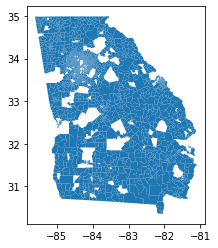

In [126]:
source_shapes.plot()

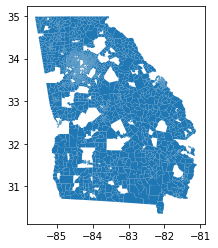

In [127]:
vest_shapes.plot()

In [131]:
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['county_prec'])
                if (diff>max_diff):
                    max_diff = diff
                    print("New max diff is: ", str(max_diff))
                    print(df.iloc[j]['county_prec'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['county_prec'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
    count_big_diff = len([i for i in diff_values if i > 5])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")

In [132]:
column_List = ['G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16USSRISA', 'G16USSDBAR', 'G16USSLBUC', 'G16PSCRECH',
       'G16PSCLHOS']
validater_row(validated_1[validated_1["final_merge"]=="both"],column_List)

There are  2183  total rows
0  of these rows have election result differences
2183  of these rows are the same

The max difference between any one shared column in a row is:  0
There are  0 precinct results with a difference greater than 5
